In [142]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

## Import Dataset

In [158]:
df = pd.read_csv('/kaggle/input/nyse/prices.csv')
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


## Sampling Google Stocks from the dataset

In [159]:
df=df[df['symbol']=='GOOGL']
df.head()

,date,symbol,open,close,low,high,volume
440,2010-01-04,GOOGL,626.950006,626.750011,624.240011,629.510005,3908400.0
908,2010-01-05,GOOGL,627.180001,623.990017,621.540016,627.839984,6003300.0
1376,2010-01-06,GOOGL,625.860033,608.260035,606.360021,625.860033,7949400.0
1844,2010-01-07,GOOGL,609.400008,594.100015,592.649990,609.999993,12815700.0
2312,2010-01-08,GOOGL,592.000005,602.020005,589.110015,603.250036,9439100.0


In [160]:
df.drop(['symbol'], axis=1, inplace=True)

In [161]:
print(f"Total number of days: {df.shape[0]}")
print(f"Total number of fields: {df.shape[1]}")

Total number of days: 1762
Total number of fields: 6


## Checking for Null Values

In [162]:
print(f"Null Values: \n{df.isnull().sum()}")

Null Values: 
date      0
open      0
close     0
low       0
high      0
volume    0
dtype: int64


## Converting Date field from string to Pandas DateTime Format

In [163]:
df['date'] = pd.to_datetime(df.date)
df.head()

,date,open,close,low,high,volume
440,2010-01-04,626.950006,626.750011,624.240011,629.510005,3908400.0
908,2010-01-05,627.180001,623.990017,621.540016,627.839984,6003300.0
1376,2010-01-06,625.860033,608.260035,606.360021,625.860033,7949400.0
1844,2010-01-07,609.400008,594.100015,592.649990,609.999993,12815700.0
2312,2010-01-08,592.000005,602.020005,589.110015,603.250036,9439100.0


# Exploratory Data Analysis (EDA)

In [164]:
startDate = df['date'].min()
endDate = df['date'].max()
duration = endDate - startDate

duration_days = duration.days
duration_years = round(duration_days / 365, 2)

print(f'Start date: {startDate}')
print(f'End date: {endDate}')
print(f'Duration in days: {duration_days}')
print(f'Duration in years: {duration_years}')

Start date: 2010-01-04 00:00:00
End date: 2016-12-30 00:00:00
Duration in days: 2552
Duration in years: 6.99


## Monthwise Analysis of Open and Close stock

In [165]:
monthvise = df.groupby(df['date'].dt.strftime('%B'))[['open','close']].mean()

newOrder = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

monthvise = monthvise.reindex(newOrder, axis=0)
monthvise

,open,close
date,,
January,710.108294,708.549290
February,713.105264,713.508748
March,720.783599,720.046541
April,636.321511,635.196305
May,620.914154,620.959326
June,608.318002,607.411670
July,642.093519,643.215209
August,660.657487,659.959616
September,664.337158,665.186187


In [166]:
colors = ['cyan', 'blue']

In [168]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x = monthvise.index,
    y = monthvise['open'],
    name ='Stock Open Price',
    marker_color=colors[0]
))

fig.add_trace(go.Bar(
    x = monthvise.index,
    y = monthvise['close'],
    name ='Stock Close Price',
    marker_color=colors[1]
))

fig.update_layout(barmode='group', title='Monthwise comparision between Open and Close Stock price')
fig.show()

## Monthwise Analysis of High and Low stock

In [171]:
df.groupby(df['date'].dt.strftime('%B'))['low'].min()

monthvise_high = df.groupby(df['date'].dt.strftime('%B'))['high'].max()
monthvise_high = monthvise_high.reindex(newOrder, axis=0)

monthvise_low = df.groupby(df['date'].dt.strftime('%B'))['low'].min()
monthvise_low = monthvise_low.reindex(newOrder, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color=colors[1]
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color=colors[0]
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

## Trend comparision between stock open price, close price, high price, low price

In [172]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(df, x = df.date, y = [df['open'], df['close'], df['high'], df['low']],
             labels={'date': 'Date','value':'Stock value'})

fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

fig.show()

## Closing Price and Moving Average

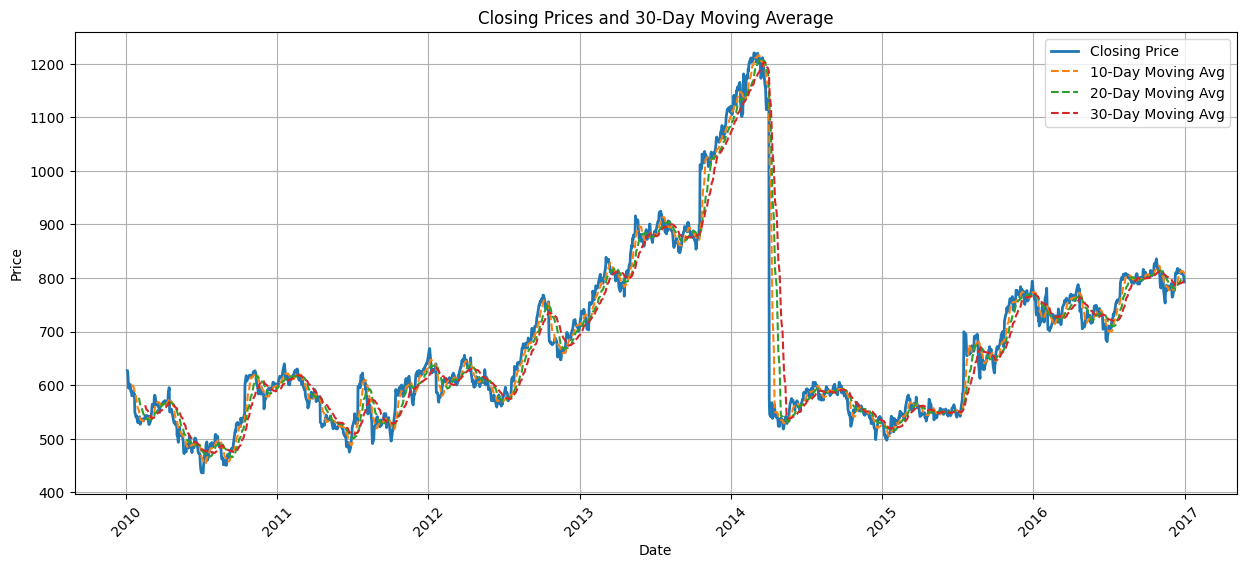

In [173]:
window_sizes = [10, 20, 30]

plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['close'], label='Closing Price', linewidth=2)
for window in window_sizes:
        
    moving_avg = df['close'].rolling(window=window).mean()

    # Plot Moving Average for each window size
    plt.plot(df['date'], moving_avg, label=f'{window}-Day Moving Avg', linestyle='--')
        
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Google Stock Volume

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0.5, 1.0, 'Google Stock volume')

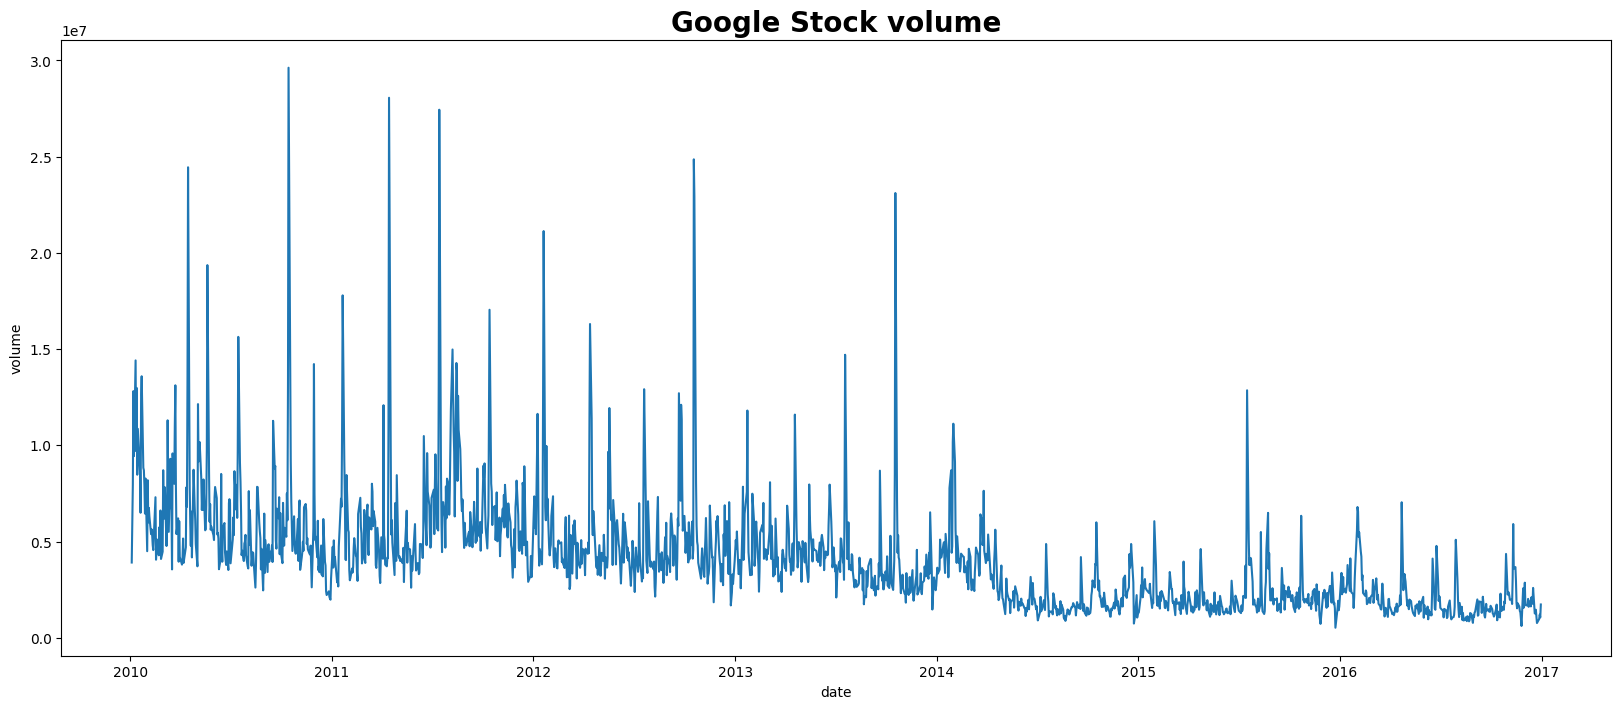

In [175]:
fig=plt.figure(figsize=(20,8))

ax=sns.lineplot(data = df, x = 'date',y = 'volume')

for s in ['left','right','top','bottom']:
    ax.spines[s].set_visible(True)

plt.title("Google Stock volume", size=20, weight='bold')

## Univariated Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

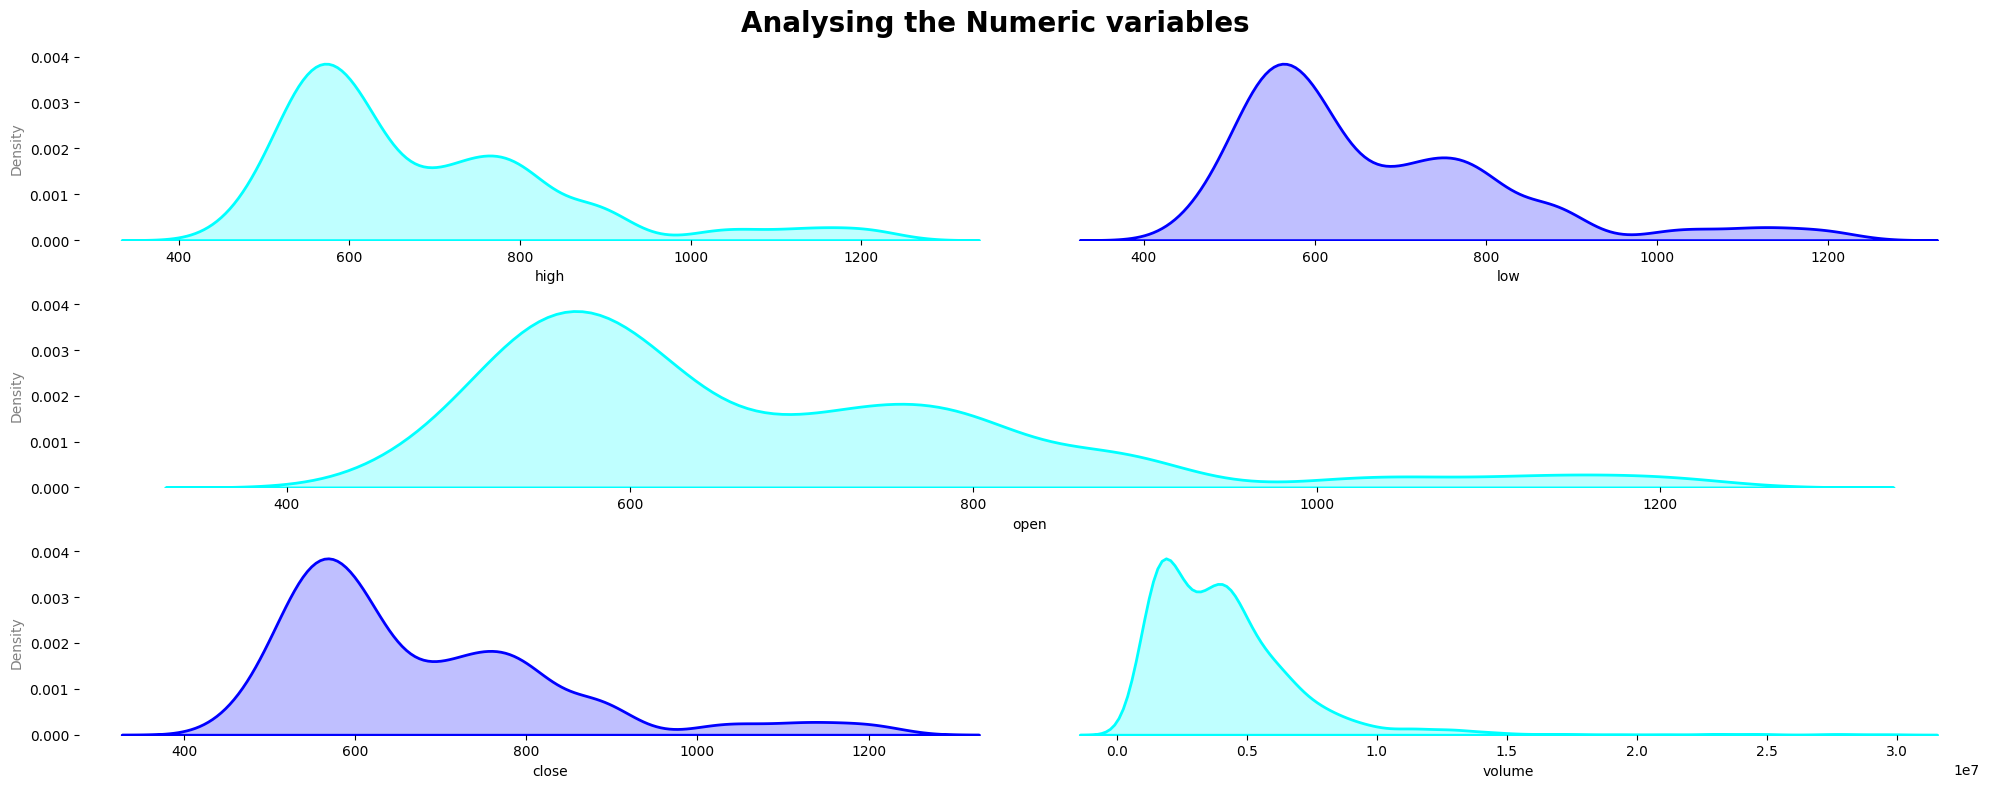

In [176]:
#integer columns
fig=plt.figure(figsize=(20,8), tight_layout=True)
plt.suptitle("Analysing the Numeric variables", size=20, weight='bold')
ax=fig.subplot_mosaic("""AB
                         CC
                         DE""")
sns.kdeplot(df['high'], ax=ax['A'], color='cyan', fill=True, linewidth=2)
sns.kdeplot(df['low'], ax=ax['B'], color='blue',fill=True, linewidth=2)
sns.kdeplot(df['open'], ax=ax['C'], color='cyan',fill=True, linewidth=2)
sns.kdeplot(df['close'], ax=ax['D'], color='blue',fill=True, linewidth=2)
sns.kdeplot(df['volume'], ax=ax['E'], color='cyan',fill=True, linewidth=2)
ax['B'].yaxis.set_visible(False)
ax['E'].yaxis.set_visible(False)
ax['A'].yaxis.label.set_alpha(0.5)
ax['C'].yaxis.label.set_alpha(0.5)
ax['A'].yaxis.label.set_alpha(0.5)
ax['C'].yaxis.label.set_alpha(0.5)
ax['D'].yaxis.label.set_alpha(0.5)
for s in ['left','right','top','bottom']:
    ax['A'].spines[s].set_visible(False)
    ax['B'].spines[s].set_visible(False)
    ax['C'].spines[s].set_visible(False)
    ax['D'].spines[s].set_visible(False)
    ax['E'].spines[s].set_visible(False)

## Box plot for finding out the outliers 

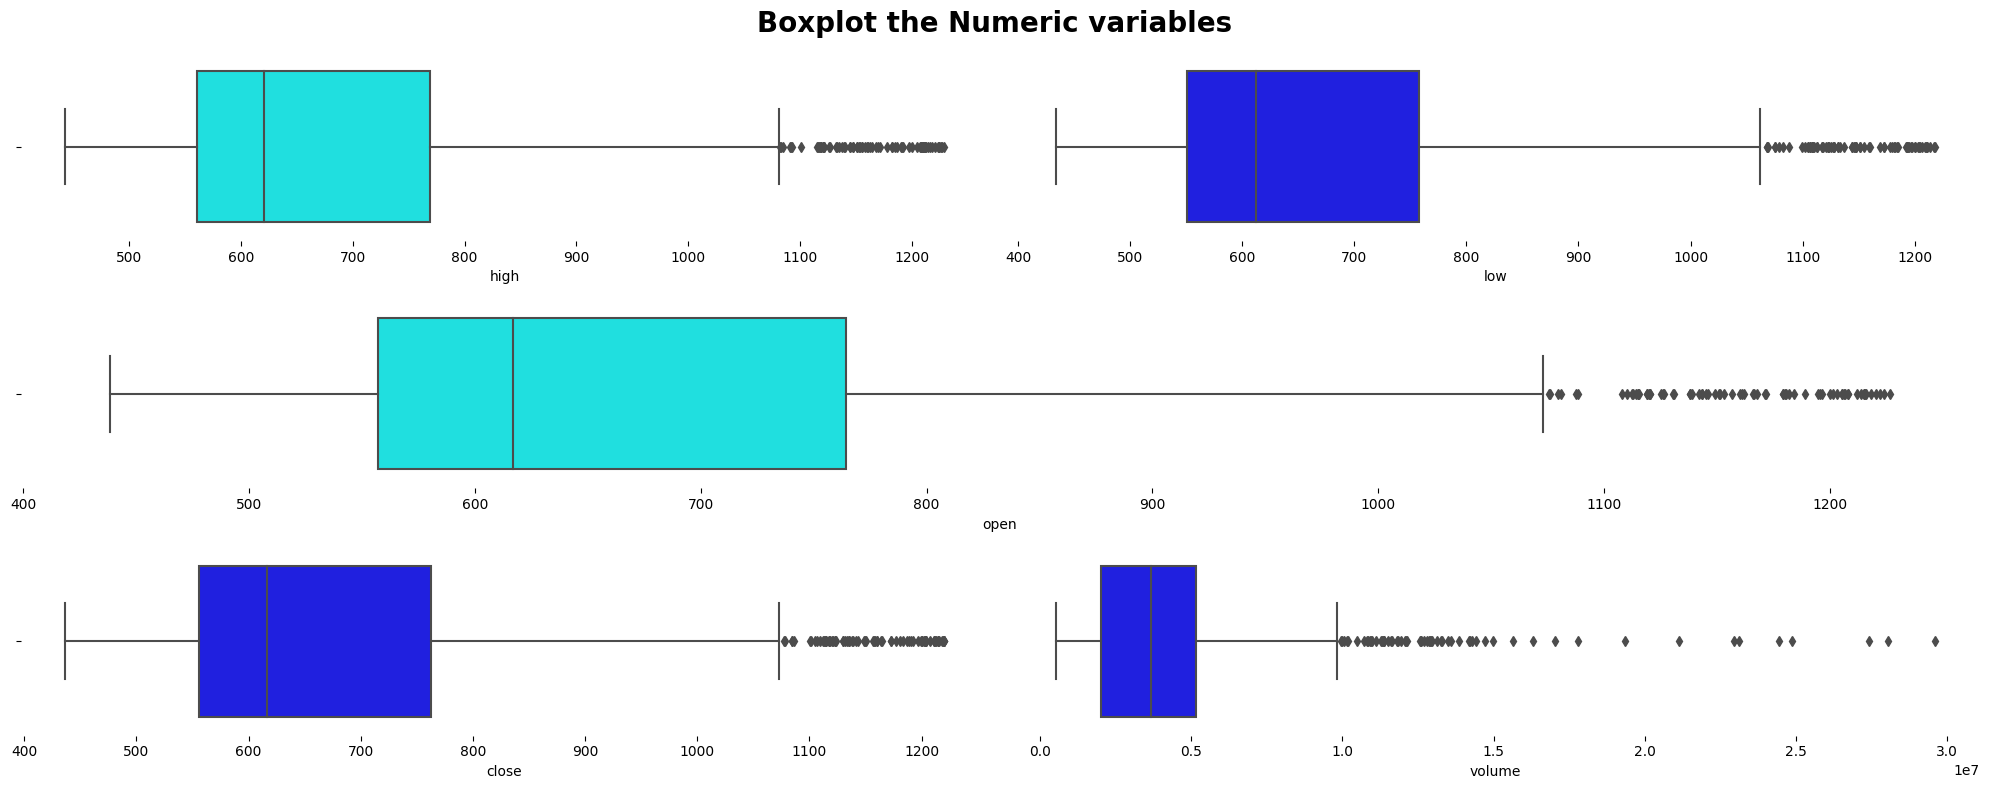

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the columns "high, low, open, close, volume"

fig = plt.figure(figsize=(20, 8), tight_layout=True)
plt.suptitle("Boxplot the Numeric variables", size=20, weight='bold')

# Define the layout of subplots
ax = fig.subplot_mosaic(
    """
    AB
    CC
    DE
    """
)

# Define colors for the boxplots
colors = ['cyan', 'blue']

# Plot boxplots
sns.boxplot(x=df['high'], ax=ax['A'], color=colors[0])
sns.boxplot(x=df['low'], ax=ax['B'], color=colors[1])
sns.boxplot(x=df['open'], ax=ax['C'], color=colors[0])
sns.boxplot(x=df['close'], ax=ax['D'], color=colors[1])

# Check if 'volume' column exists in the DataFrame
if 'volume' in df.columns:
    sns.boxplot(x=df['volume'], ax=ax['E'], color=colors[1])
    ax['E'].yaxis.set_visible(False)

# Hide y-axis for specific subplots
ax['B'].yaxis.set_visible(False)
ax['A'].yaxis.label.set_alpha(0.5)
ax['C'].yaxis.label.set_alpha(0.5)
ax['D'].yaxis.label.set_alpha(0.5)

# Hide spines for all subplots
for s in ['left', 'right', 'top', 'bottom']:
    for key in ax.keys():
        ax[key].spines[s].set_visible(False)

plt.show()


In [178]:
def calculate_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers

# Calculate outliers percentage for each column
outliers_percentage = {}
for col in df.columns:
    outliers = calculate_outliers_iqr(df[col])
    outliers_percentage[col] = outliers.mean() * 100

# Print outliers percentage for each column
for col, percentage in outliers_percentage.items():
    print(f"Percentage of outliers in '{col}': {percentage:.2f}%")

Percentage of outliers in 'date': 0.00%
Percentage of outliers in 'open': 4.26%
Percentage of outliers in 'close': 4.26%
Percentage of outliers in 'low': 4.31%
Percentage of outliers in 'high': 4.31%
Percentage of outliers in 'volume': 3.46%


There are some outliers as seen in the visualization. We can also observe the percentage of the outliers in each column. But we can't conclude them as outlier as they may be the extreme values during peak selling days or bubble burst. 

## Normality in the Dataset

In [179]:
from scipy.stats import shapiro

# Select integer columns for Shapiro-Wilk test
int_cols = df.select_dtypes(include='number').columns.tolist()

for col in int_cols:
    _, p_value = shapiro(df[col])
    if p_value < 0.05:
        print("Feature {} is not normally distributed".format(col))
    else:
        print("Feature {} is normally distributed".format(col))
    print("Normality test p-value for feature {} is {}".format(col, round(p_value, 3)))

Feature open is not normally distributed
Normality test p-value for feature open is 0.0
Feature close is not normally distributed
Normality test p-value for feature close is 0.0
Feature low is not normally distributed
Normality test p-value for feature low is 0.0
Feature high is not normally distributed
Normality test p-value for feature high is 0.0
Feature volume is not normally distributed
Normality test p-value for feature volume is 0.0


## Correlation

<Axes: >

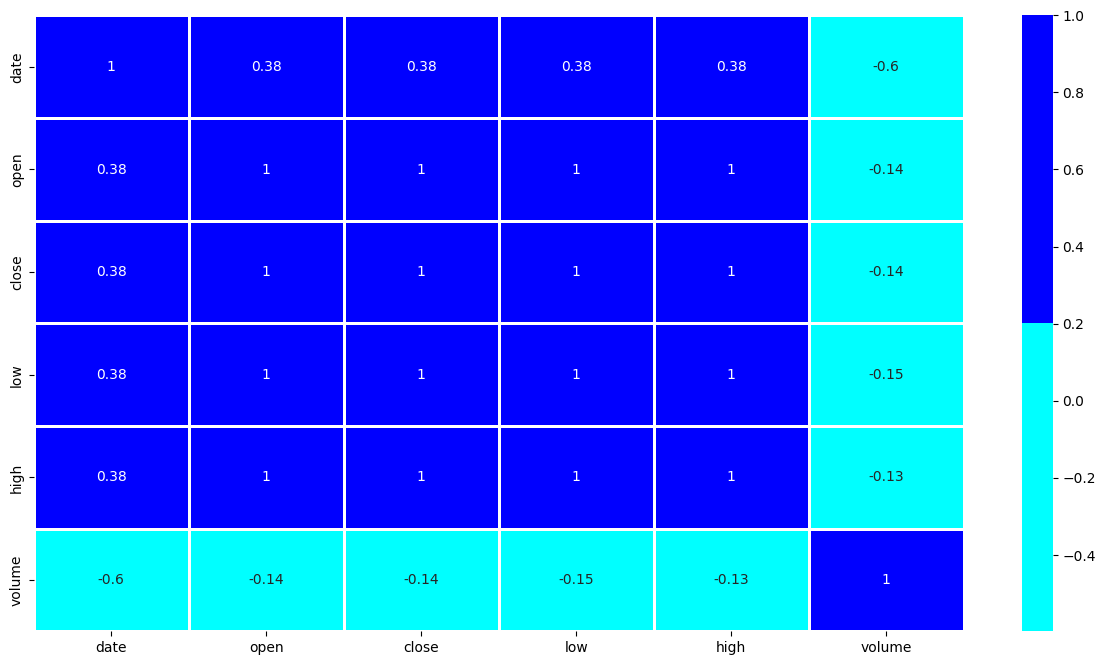

In [180]:
fig = plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, cmap=[colors[0],colors[1]], linecolor='white', linewidth=2 )

We can observe features: open, close, low and high are highly correlated to each other. We can use either of these features for our prediction. We are going to use close for training and prediction 

## Preparing close stock price 

In [181]:
closeDf = df[['date','close']]
print(f"Shape of close dataframe: {closeDf.shape}")

Shape of close dataframe: (1762, 2)


**Visualize close stock**

In [182]:
fig = px.line(closeDf, x=closeDf.date, y=closeDf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

**Preparing the data for training and test**

In [183]:
del closeDf['date']
closeDf.shape

(1762, 1)

**Dividing close stock into 70% training data and 30% testing data.**

In [184]:
training_size = int(closeDf.shape[0] * 0.70)
test_size = int(closeDf.shape[0] - training_size)

train_data = closeDf.iloc[:training_size, :]
test_data = closeDf.iloc[training_size:, :]

print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1233, 1)
test_data:  (529, 1)


**Normalize the training and test data**

In [185]:
sc = MinMaxScaler()

train_data_normalized = sc.fit_transform(train_data)
test_data_normalized = sc.transform(test_data)

print(f"Normalized train_data: \n{train_data_normalized[:10]}\n")
print(f"Normalized test_data: \n{test_data_normalized[:10]}")

Normalized train_data: 
[[0.24318329]
 [0.23966334]
 [0.21960214]
 [0.2015432 ]
 [0.21164394]
 [0.2104834 ]
 [0.19692639]
 [0.19260299]
 [0.19612295]
 [0.18356077]]

Normalized test_data: 
[[0.14431831]
 [0.14240528]
 [0.14412705]
 [0.13210053]
 [0.13074867]
 [0.12868253]
 [0.13583729]
 [0.11734475]
 [0.12072438]
 [0.12758575]]


## Transforming close price based on Time-series-analysis forecasting requirement

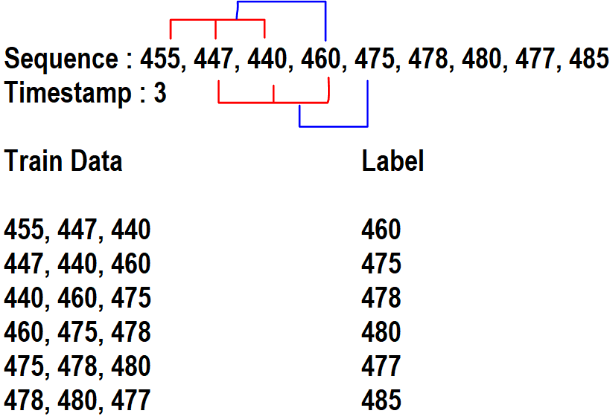

In the given time series data. We select the the N-time_steps, following by N-time_steps[i] + 1 as the label.
We keep on going until we have exhausted all the time series data points. Note that this datastructure will always contain the total data points in the time_series_data - time_steps.  

In [186]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [187]:
time_step = 30
X_train, y_train = create_dataset(train_data_normalized, time_step)
X_test, y_test = create_dataset(test_data_normalized, time_step)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (1202, 30)
y_train: (1202,)
X_test: (498, 30)
y_test: (498,)


**reshape input to be [samples, time steps, features] which is required for LSTM**

In [188]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1202, 30, 1)
X_test:  (498, 30, 1)


# Model Building

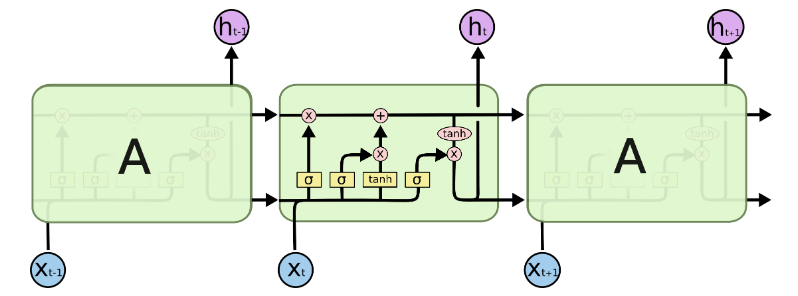

Image Reference: [Here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

Follow below reference links tto know more about GRU and LSTM:

[Comprehensive guide about LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [189]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [190]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [191]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.keras', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0523 - val_loss: 0.0029
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0100 - val_loss: 0.0020
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0088 - val_loss: 0.0015
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0099 - val_loss: 0.0011
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0071 - val_loss: 0.0014
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0078 - val_loss: 0.0014
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 21/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 22/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0030 - val_loss: 7.1229e-04
Epoch 23/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 24/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0033 - val_loss: 8.0983e-04
Epoch 25/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s

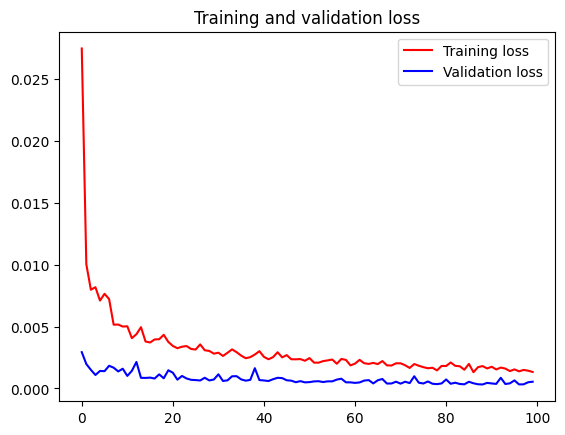

<Figure size 640x480 with 0 Axes>

In [192]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [193]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

train_predict.shape, test_predict.shape

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


((1202, 1), (498, 1))

# Model Evaluation

In [194]:
train_predict = sc.inverse_transform(train_predict)
test_predict = sc.inverse_transform(test_predict)
original_ytrain = sc.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = sc.inverse_transform(y_test.reshape(-1,1)) 

**Evaluation metrices RMSE, MSE and MAE**

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data

In [195]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  22.87023690074528
Train data MSE:  523.0477358962111
Train data MAE:  12.155145621496724
-------------------------------------------------------------------------------------
Test data RMSE:  14.127419704384746
Test data MSE:  199.5839875038384
Test data MAE:  9.945549289117409


**Explained variance regression score**

The explained variance score explains the dispersion of errors of a given dataset. Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [196]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9845086959511244
Test data explained variance regression score: 0.9791341218880216


**R2 score for regression**

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. . Scores close to 1.0 are highly desired

In [197]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9843658545147471
Test data R2 score: 0.9787331716415445


# Comparision of original stock close price and predicted close price

In [198]:
look_back = time_step
trainPredictPlot = np.empty_like(closeDf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(closeDf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back * 2) + 1:len(closeDf) - 1, :] = test_predict

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': df['date'],
                       'original_close': df['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf, x=plotdf['date'], 
              y=[plotdf['original_close'], plotdf['train_predicted_close'], plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})

fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# Plotting entire Closing Stock Price with next 30 days period of prediction

In [199]:
x_input = test_data.values[len(test_data)-time_step:].reshape(1, -1)

temp_input = list(x_input)
temp_input= temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 30
while(i < pred_days):
    
    if(len(temp_input)> time_step):
        
        x_input=np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [200]:
lstmdf = closeDf.values.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf = sc.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf, labels={'value': 'Stock price', 'index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Stock')

fig.for_each_trace(lambda t: t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()